In [14]:
'''
kurze Erklärung zu den Notebooks:

"parquets_find_sections.ipynb"
---------------------------------

Dient zum  Aufteilen der parquet-Files in Abschnitte. Es werden Keine Signale entfernt oder Werte verändert, sondern nur
die einzelnen DataFrames in mehrere neue aufgespalten und mit fortlaufender Nummerierung (z.B. "V101_T16.parquet") abgespeichert. Output am
besten in Neuen Ordner verlegen. Alte Dateien werden nicht verändert.

    Zelle 3: Pfade eintragen, wo die parquet-Dateien liegen und wo ggf. neue Dateien gespeichert werden sollen 
    Zelle 6: War für mein Preprocessing notwendig, um Signale auzuwählen. kann hier ignoriert werden

    Hauptteil in Zelle 9:
        - einfach mal ausprobieren ob es funktioniert (Zelle wiederholen für neues Beispiel)
        - Diagramm unten veranschaulicht die ausgewählten Sequenzen
        - Für das Bearbeiten und speichern aller Dateien, setze save = True, plot = False und sample_only = False
        - Zeilen 141 bis 156, um die wesentlichen Anforderungen festzulegen

    Zelle 10: zeigt die Abschnitte aus Zelle 9 nochmals im Detail


"parquets_clean_sections.ipynb"
---------------------------------

Weitergehendes Preprocessing. Hier werden die Abschnitte aus "parquets_find_sections.ipynb" bearbeitet. Es werden Signale entfernt, aufgefüllt,
und ggf. fehlerhafte Abschnitte entfernt. s. Code.

''';

In [15]:
#%reset -f 
import sys, os, pickle, random
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
import matplotlib.pyplot as plt

from datetime import datetime
from pathlib import Path
from scipy.signal import savgol_filter
from scipy.stats import zscore, median_abs_deviation
from itertools import groupby

from IPython.core.magic import register_cell_magic
@register_cell_magic
def skip(line, cell): return  # cells can be skipped by using '%%skip' in the first line

In [16]:
# -----------> SET DATA FOLDER LOCATION HERE:
#DATA_PATH = Path('/home', 'sieglew', 'MA-Data')
DATA_PATH = Path(r'/mnt/nvme/datasets')

# FILE SOURCES ---------------------------------------------------------------
original_trips_folder = Path(DATA_PATH, "volts") # original Trip parquet files

# OUTPUT LOCATIONS ---------------------------------------------------------------
trips_processed_final = Path(DATA_PATH, "new_folder") # Save new files here

In [17]:
# GET DIRECTORY CONTENTS:
def get_files(folder, ext, full = False): return [file if full else file.name for file in folder.glob(f'*{ext}')]
trips = get_files(original_trips_folder, ".parquet", full = False)
len(trips)

2647

In [18]:
# get list of signals
df = pd.read_parquet(Path(original_trips_folder, trips[0]), engine='fastparquet')
all_columns = df.columns
#assert len(all_columns) == 114

In [19]:
# UTILS
####################################################################################################
def expand_indices(r_list, ws, offset, max_val):
    r_set = set(r_list).copy()
    for i in range(-ws,ws+1):
        r_set = r_set | set([x+i for x in r_list])
    r_set = [x+offset for x in list(r_set)]
    drops = [x for x in list(r_set) if (x>=0 and x<max_val)]
    return sorted(drops)

####################################################################################################   
def smooth_filter(X, ws, remove_outliers = True, smooth = True):

    def custom_filter(X,ws, remove_outliers, thresh = 8):
        X_filtered = X.copy()
        X_noise  = abs(zscore(X.ffill().bfill() - savgol_filter(X.ffill().bfill(), ws,1, mode='nearest'), nan_policy='omit'))
        if remove_outliers:
            cr = X.std() - median_abs_deviation(X, nan_policy='omit')
            thresh_new = max(abs(X.std() / cr), thresh) if cr != 0 else max(abs(X.std()), thresh)
            peaks = expand_indices(list(np.where((X_noise > thresh_new))[0]), int(ws), 0, len(X))
            X_filtered[peaks] = np.nan
            X_filtered[X_noise.isna()] = np.nan
        else:
            thresh_new = None

        if X_filtered.nunique() < 2:
            X_filtered.fillna(X_filtered.mean(), inplace=True)
        else:
            X_filtered.ffill(inplace=True)
            X_filtered.bfill(inplace=True)  

        return X_filtered, X_noise, thresh_new

    X_filtered, X_noise, thresh = custom_filter(X, ws, remove_outliers = remove_outliers)
    
    if (X - X_filtered).std() > 10:
        X_filtered, X_noise, thresh = custom_filter(X_filtered, ws, remove_outliers = remove_outliers)

    if smooth: X_filtered = savgol_filter(X_filtered, ws/2,1, mode='nearest')
    return X_filtered, X_noise, thresh

####################################################################################################
def get_slices(c_state, min_length=60, exp=lambda val: val == 0):
        slices = []
        start = None
        for i, val in enumerate(c_state):
            condition = exp(val)
            if condition and start is None:
                    start = i
            elif not condition and start is not None:
                    if (i - start) >= min_length:
                        slices.append(slice(start, i))
                    start = None
        if start is not None and (len(c_state) - start) >= min_length:
            slices.append(slice(start, len(c_state)))
        return slices

####################################################################################################
def intersect_slices(slices_A, slices_B):
    intersection_slices = []
    for v_slice in slices_A:
        for c_slice in slices_B:
            start = max(v_slice.start, c_slice.start)
            stop = min(v_slice.stop, c_slice.stop)
            if start < stop:
                intersection_slices.append(slice(start, stop))
    return intersection_slices

####################################################################################################
def split_dataframe_by_slices(df, slices):
    return [df.iloc[s] for s in slices]

####################################################################################################
idx_dict = {}
def save_dataframes_to_parquet(dataframes, base_path, idx_dict, veh_id):
    if f"{veh_id}" not in idx_dict: idx_dict[f"{veh_id}"] = 0
    start_idx = idx_dict[f"{veh_id}"]+1
    new_files = []
    for i, df in enumerate(dataframes):
        filename = f"V{veh_id}_T{i+start_idx}.parquet"
        new_files.append(filename)
        df.to_parquet(Path(base_path, filename), engine='fastparquet')
    idx_dict[f"{veh_id}"] = start_idx + i
    return new_files, idx_dict

####################################################################################################
def find_nan_sections(series):
    nan_sections = []
    start_idx = None

    for idx, value in series.isna().items():
        if value and start_idx is None:
            start_idx = idx
        elif not value and start_idx is not None:
            if idx > start_idx + 2:
                nan_sections.append(start_idx)
            start_idx = None

    if start_idx is not None:
        nan_sections.append(start_idx)

    # Remove neighboring numbers
    nan_sections = [nan_sections[i] for i in range(len(nan_sections)) if i == 0 or nan_sections[i] != nan_sections[i-1] + 1]

    return nan_sections

0: v_id983V14_trip216.parquet
	Vehicle ID: 14, File Code: V14_trip216, Prefix: v_id983
117
		Section 0 from 8572 to 9215, length: 643, mean speed: 10.94
		Section 1 from 10343 to 12581, length: 2238, mean speed: 23.42
		Section 2 from 12800 to 13634, length: 834, mean speed: 16.91
		Section 3 from 14144 to 15015, length: 871, mean speed: 32.53
		Section 4 from 15595 to 28446, length: 12851, mean speed: 47.48
		Section 5 from 28686 to 41513, length: 12827, mean speed: 55.03
		Section 6 from 42130 to 56142, length: 14012, mean speed: 45.89
		Section 7 from 58211 to 59388, length: 1177, mean speed: 6.18
		Section 8 from 62019 to 62231, length: 212, mean speed: 8.06
		Section 9 from 93015 to 102897, length: 9882, mean speed: 38.64
		Section 10 from 103442 to 133378, length: 29936, mean speed: 68.85


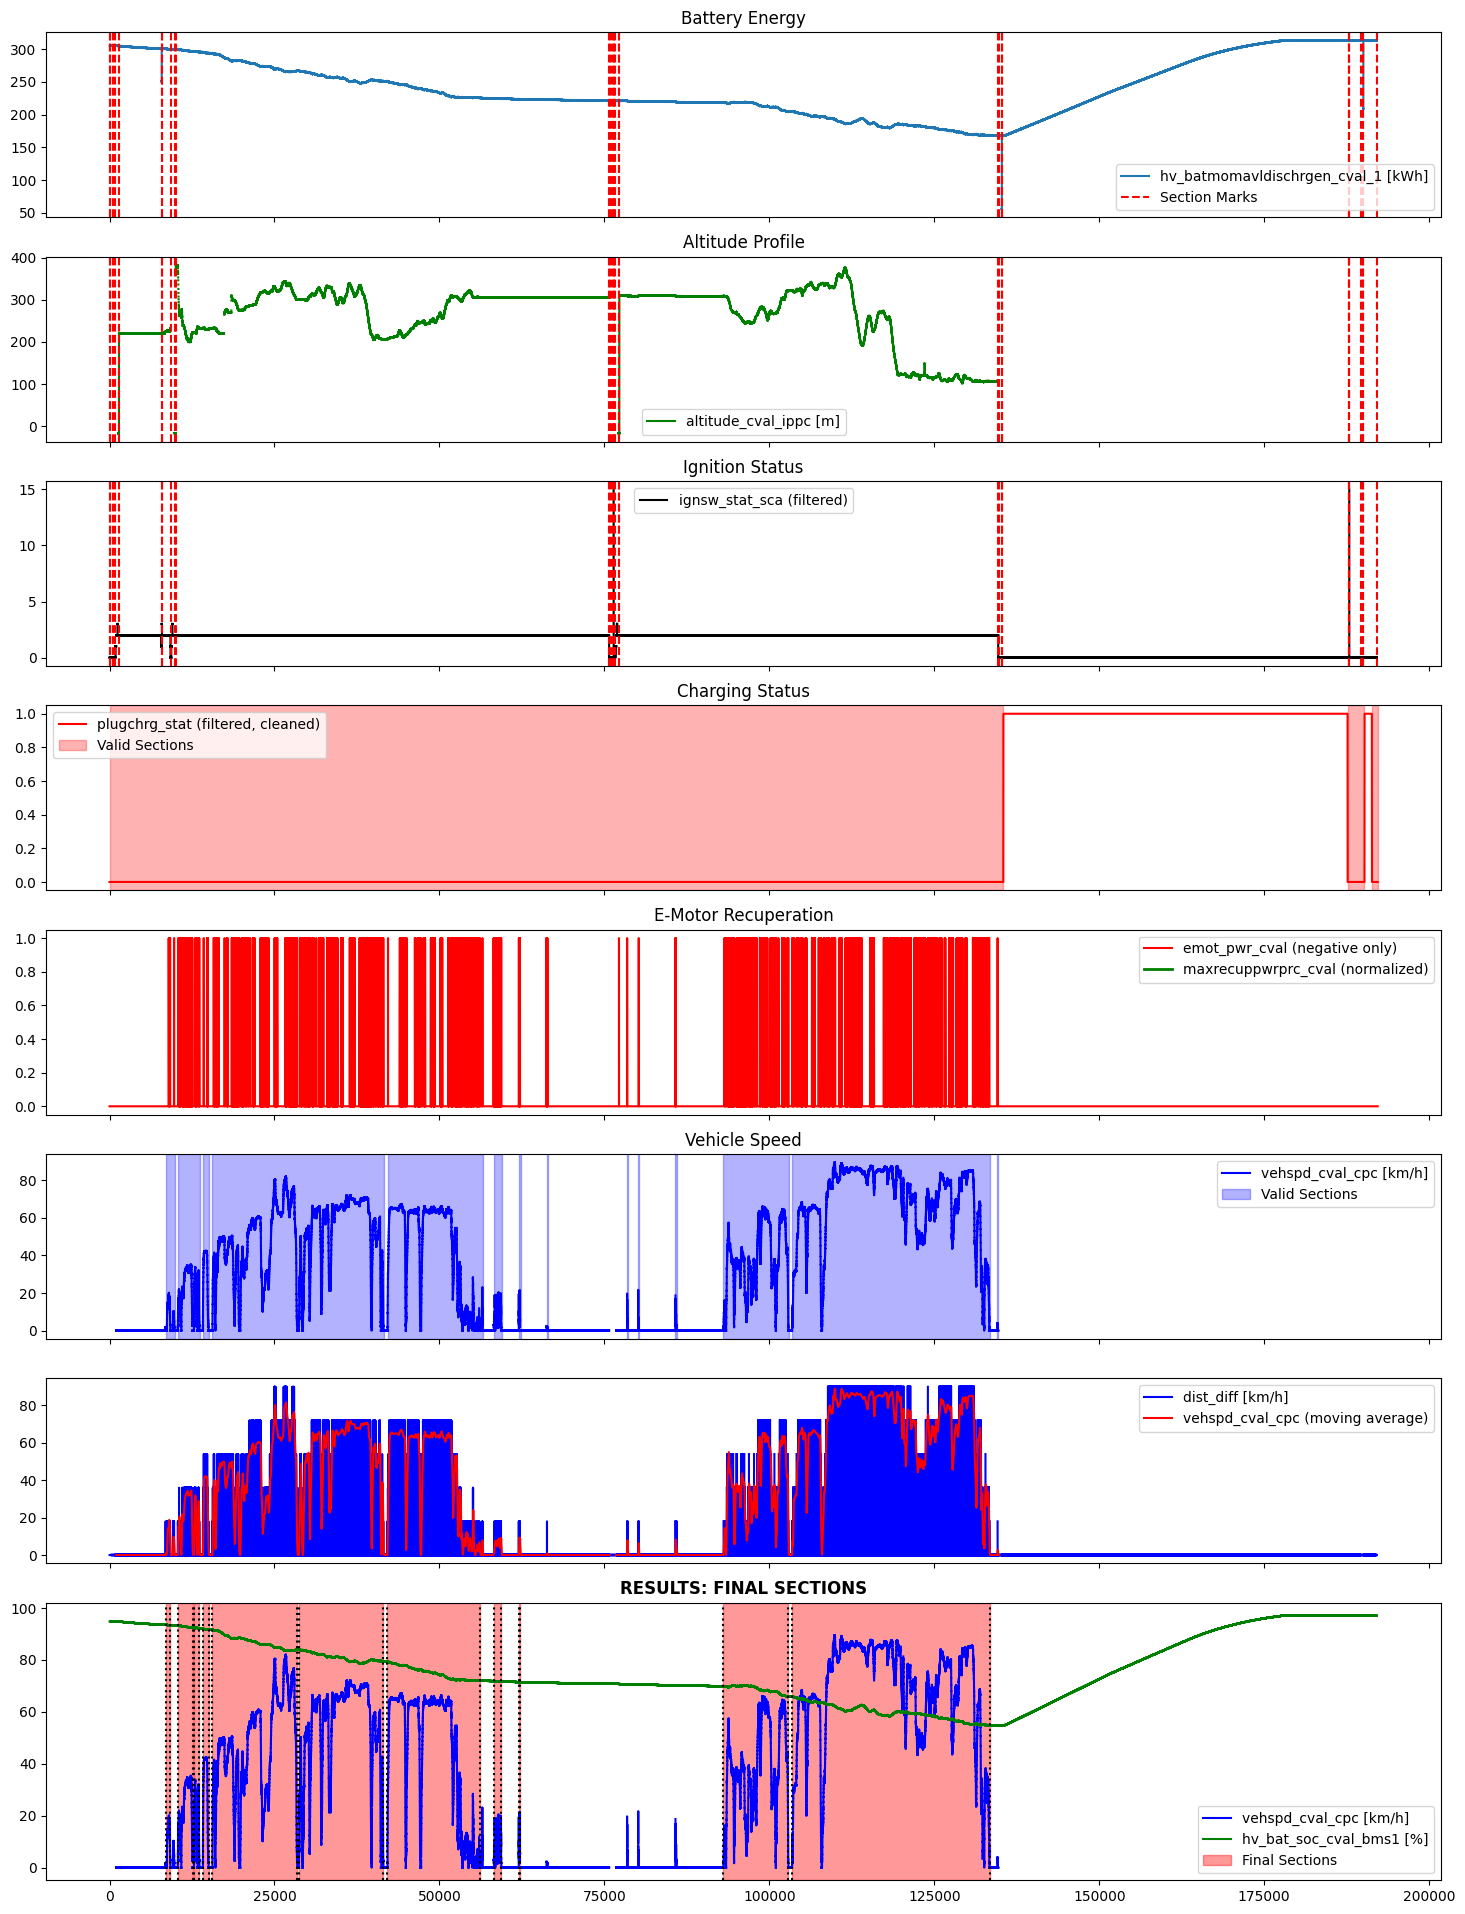

In [26]:
# SECTIONING OF TRIPS
# -----------------------------------------------------------------------------------------------
# -----------------------------------------------------------------------------------------------
# Note: 
    # for experimental purposes: save = False, plot = True, sample_only = True (REPEAT CELL FOR NEW SAMPLE)
    # for final processing: save = True, plot = False, sample_only = False
save = False
plot = True
sample_only = True

# -----------------------------------------------------------------------------------------------
empty_files = []        # collect parquet files without valid sections found
nan_table = []          # summarize nan percentages

# -----------------------------------------------------------------------------------------------
for n, f in enumerate(random.sample(trips, 1) if sample_only else trips):

    if not sample_only and plot: 
        print("disable 'plot'!")
        break

    # READ FILE ---------------------------------------------------------------
    #f = "v_id983V17_trip195.parquet"
    print(f"{n}: {f}"); vehicle_id = f[8:11].strip("_t"); file_code = f[7:-8]; prefix = f[:7]
    print(f"\tVehicle ID: {vehicle_id}, File Code: {file_code}, Prefix: {prefix}")

    df = pd.read_parquet(Path(original_trips_folder, f), engine='fastparquet')
    df.sort_index(axis=1, inplace=True)
    if len(df.columns) != 114: print(len(df.columns))
    # df.reset_index(drop=True, inplace=True)
    
    # SIGNALS ---------------------------------------------------------------
    # assign important signals to variables
    alt, lat, ign = df["altitude_cval_ippc"], df["latitude_cval_ippc"], df["ignsw_stat_sca"]
    dist, v, en = df["hirestotalvehdist_cval_icuc"], df["vehspd_cval_cpc"], df["hv_batmomavldischrgen_cval_1"]
    soc, emot, maxrecup = df["hv_bat_soc_cval_bms1"], df["emot_pwr_cval"], df["maxrecuppwrprc_cval"]
    c_state = df["plugchrg_stat"].where(df["plugchrg_stat"].isin([0, 1])).ffill().bfill()

    # first derivative of certain signals to indicate significant jumps
    alt_diff = pd.DataFrame(abs(np.diff(alt.ffill().bfill())))
    lat_diff = pd.DataFrame(abs(np.diff(lat.ffill().bfill())))
    en_diff = pd.DataFrame(abs(zscore(np.diff(en.ffill().bfill()), nan_policy='omit')))
    ign_diff = pd.DataFrame(abs(zscore(np.diff(ign.ffill().bfill()), nan_policy='omit')))

    # TENTATIVE SPLITTING MARKS ---------------------------------------------------------------
    # Combine split indices from different conditions
    split_indices = alt_diff[alt_diff[0] > 50].index.union(
                    lat_diff[lat_diff[0] > 10].index).union(
                    en_diff[en_diff[0] > 15].index).union(
                    ign_diff[ign_diff[0] > 20].index)

    split_indices = split_indices.union(find_nan_sections(en))
    # if split_indices.empty: continue

    # TENTAIVE SLICING BASED ON CHARGING STATUS AND SPEED SIGNALS -----------------------------
    # obtain slices from charging status and speed signal -------------------------------------
    c_slices = get_slices(c_state)

    v_filtered = v.rolling(window=80, min_periods=1).mean()
    v_sections = get_slices(v_filtered, min_length=120, exp = lambda val: val > 0)

    # Merge sections if they are separated by less than merge_threshold
    v_slices = []
    merge_threshold = 60
    for i, section in enumerate(v_sections):
        merge_threshold += abs((section.stop - section.start))/2
        merge_threshold = min(merge_threshold, 6*60)	
        #print(merge_threshold)
        if v_slices and section.start - v_slices[-1].stop < merge_threshold:
            v_slices[-1] = slice(v_slices[-1].start, section.stop)
        else:
            v_slices.append(section)
    
    # merge sections from v_slices and c_slices
    sections = intersect_slices(v_slices, c_slices)


    # PROCESSING OF OBTAINED SECTIONS AND SPLIT MARKS ---------------------------------------------------------------
    # ---------------------------------------------------------------------------------------------------------------
    # remove overlapping slices ---------------------------------------------------------------
    for i, s1 in enumerate(sections):
        for j, s2 in enumerate(sections):
            if i != j:
                start = max(s1.start, s2.start)
                stop = min(s1.stop, s2.stop)
                if start < stop:
                    print(f"Intersection found between section {i} and section {j}: {slice(start, stop)}")
                    if s1.stop - start < stop - s2.start:
                        sections[i] = slice(s1.start, start)
                    else:
                        sections[j] = slice(stop, s2.stop)
                    print(f"Section overlaps removed.")
  
    # SPLIT SECTIONS BASED ON ENERGY DIFFERENCE THRESHOLD ------------------------------
    #if split_indices is not None: print(f"Split indices: {split_indices}")
    for split_idx in split_indices:
        for i, s in enumerate(sections):
            if s.start < split_idx < s.stop:
                sections[i] = slice(s.start, split_idx)
                sections.insert(i + 1, slice(split_idx, s.stop))

    # SPLIT SECTIONS BASED ON VEHICLE SPEED BREAKS -------------------------------------
    for i, s in enumerate(sections):
        if (((v[section] == 0).mean()>0.5 or v[section].isna().mean()>0.5) and (s.stop-s.start) > 4*60) \
            or (((v[section] == 0).mean()>0.2 or v[section].isna().mean()>0.2) and (s.stop-s.start) > 20*60):
            invalid_indices = v[s][(v[s] == 0) | (v[s].isna())].index
            if len(invalid_indices) > 0:
                longest_inv_seq = max((list(g) for _, g in groupby(enumerate(invalid_indices), lambda ix: ix[0] - ix[1])), key=len)
                first_index = longest_inv_seq[0][1]
                last_index = longest_inv_seq[-1][1]
                if last_index - first_index > 2*60:
                    sections[i] = slice(s.start, first_index)
                    sections.insert(i + 1, slice(last_index, s.stop))

    # remove trailing zeros and nans ---------------------------------------------------------------
    for i, s in enumerate(sections):
        if s.stop < len(v)-1:
            if len(v[s]) > 0:
                if v[s].iloc[-1] == 0 or pd.isna(v[s].iloc[-1]):
                    if v[s][v[s] != 0].last_valid_index() is not None:
                        sections[i] = slice(s.start, v[s][v[s] != 0].last_valid_index()+2)
                elif v[s].last_valid_index() is not None:
                    if v[v[s].last_valid_index()+1] == 0:
                        sections[i] = slice(s.start, v[s].last_valid_index()+2)
        elif v[s].iloc[-1] == 0 or pd.isna(v[s].iloc[-1]):
            if v[s][v[s] != 0].last_valid_index() is not None:
                try:
                    sections[i] = slice(s.start, v[s][v[s] != 0].last_valid_index()+2)
                except:
                    sections[i] = slice(s.start, v[s][v[s] != 0].last_valid_index()+1)

    # remove leading zeros and nans ---------------------------------------------------------------
    for i, s in enumerate(sections):  
        if v[s][v[s] != 0].first_valid_index() is not None:
            if s.start > 0  and v[v[s].first_valid_index()-1] == 0:        
                sections[i] = slice(v[s][v[s] != 0].first_valid_index()-1, s.stop)
            else:
                sections[i] = slice(v[s][v[s] != 0].first_valid_index(), s.stop)

    # FINAL CHECK OF FOUND SECTIONS, BASED ON CRITERIA ---------------------------------------------------------------
    # discard sections that are either too short or too slow or have too many target nans ----------------------------
    sections = [_ for _ in sections \
            # MIN SECTION LENGTH: 120 seconds
                if (_.stop - _.start) >= 60 \
            # MIN AVERAGE SPEED: 3 km/h          
                and v[_.start:_.stop].mean() > 3 \
            # MIN TOP SPEED: 5 km/h
                and v[_.start:_.stop].max() > 5 \
            # MAX STANDING (SPEED=0) PERCENTAGE: 60%
                and (v[_.start:_.stop] == 0).mean() < 0.6 \
            # MAX NAN PERCENTAGE (SPEED): 20%   
                and v[_.start:_.stop].isna().mean() < 0.2\
            # MAX NAN PERCENTAGE (EN): 20% 
                and en[_.start:_.stop].isna().mean() < 0.2 \
            # MIN NUMBER OF UNIQUE EN VALUES: 5
                and en[_.start:_.stop].nunique() > 5
                ]

    # OUTPUT INFO ON FINAL SECTIONS ---------------------------------------------------------------
    for i, section in enumerate(sections):
        print(f"\t\tSection {i} from {section.start} to {section.stop}, length: {section.stop - section.start}, mean speed: {v[section.start:section.stop].mean():.2f}")

    # VISUALIZATION ---------------------------------------------------------------
    if plot:
        fig, axes = plt.subplots(nrows=8, ncols=1, figsize=(18, 24), sharex=True, gridspec_kw={'height_ratios': [1, 1, 1, 1, 1, 1, 1, 1.5]})
        # ---------------------------------------------------------------
        ax = axes[0]
        en.plot(ax=ax, title="Battery Energy")
        for idx in split_indices: ax.axvline(x=idx, color='r', linestyle='--')
        handle = plt.Line2D([0], [0], color='r', linestyle='--')
        ax.legend(labels=['hv_batmomavldischrgen_cval_1 [kWh]', 'Section Marks'])
        # ---------------------------------------------------------------
        ax = axes[1]
        alt.plot(ax=ax, title="Altitude Profile", color='g')
        ax.legend(labels=['altitude_cval_ippc [m]'])
        for idx in split_indices: ax.axvline(x=idx, color='r', linestyle='--')
        # ---------------------------------------------------------------
        ax = axes[2]
        ign.plot(ax=ax, title="Ignition Status", color='k')
        ax.legend(labels=['ignsw_stat_sca (filtered)'])
        for idx in split_indices: ax.axvline(x=idx, color='r', linestyle='--')
        # ---------------------------------------------------------------
        ax=axes[3]
        c_state.plot(ax=ax, color='r', title="Charging Status")
        for section in c_slices: ax.axvspan(section.start, section.stop, color='red', alpha=0.3)
        ax.legend(labels=['plugchrg_stat (filtered, cleaned)', 'Valid Sections'])
        # ---------------------------------------------------------------
        ax=axes[4]
        pd.DataFrame((emot < 0).astype(int)).plot(ax=ax, color='r')
        pd.DataFrame(maxrecup/max(maxrecup)).plot(ax=ax, color='g', title="E-Motor Recuperation", linewidth=2)
        ax.legend(labels=['emot_pwr_cval (negative only)', 'maxrecuppwrprc_cval (normalized)'])
        # ---------------------------------------------------------------
        ax=axes[5]
        v.plot(ax=ax, color='b', title="Vehicle Speed")
        for section in v_slices: ax.axvspan(section.start, section.stop, color='b', alpha=0.3)
        ax.legend(labels=['vehspd_cval_cpc [km/h]', 'Valid Sections'])
        # ---------------------------------------------------------------
        ax=axes[6]
        pd.DataFrame(np.diff(dist)*3600).plot(ax=ax, color='b')
        v_filtered.plot(ax=ax, color='r')
        ax.legend(labels=['dist_diff [km/h]', 'vehspd_cval_cpc (moving average)'])
        # ---------------------------------------------------------------
        ax=axes[7]
        v.plot(ax=ax, color='b')
        soc.plot(ax=ax, color='g')
        ax.set_title("RESULTS: FINAL SECTIONS", fontweight='bold')
        for section in sections:
            ax.axvspan(section.start, section.stop, color='red', alpha=0.4)
            ax.axvline(x=section.start, color='k', linestyle=':')
            ax.axvline(x=section.stop, color='k', linestyle=':')
        ax.legend(labels=['vehspd_cval_cpc [km/h]', 'hv_bat_soc_cval_bms1 [%]', 'Final Sections'])
        # ---------------------------------------------------------------
        plt.show()

    # SAVE ---------------------------------------------------------------
    if not sections: 
        print(f"------> No valid sections found in {f}\n{'-'*120}\n")
        empty_files.append(f)
    else:
        if save:
            sliced_sections = split_dataframe_by_slices(df, sections)
            saved_sections, idx_dict = save_dataframes_to_parquet(sliced_sections, trips_processed_final, idx_dict, vehicle_id)
            print(f"\t{len(saved_sections)} sections found.")
            print(f"\t\t{saved_sections}, veh_idx: {idx_dict}")
            for i, sliced_section in enumerate(sliced_sections):
                nan_percentage = sliced_section.isna().mean() * 100
                nan_table.append((f, saved_sections[i], nan_percentage))

section 0
length: 643
speed (start, end): (np.float64(0.0), np.float64(0.0))


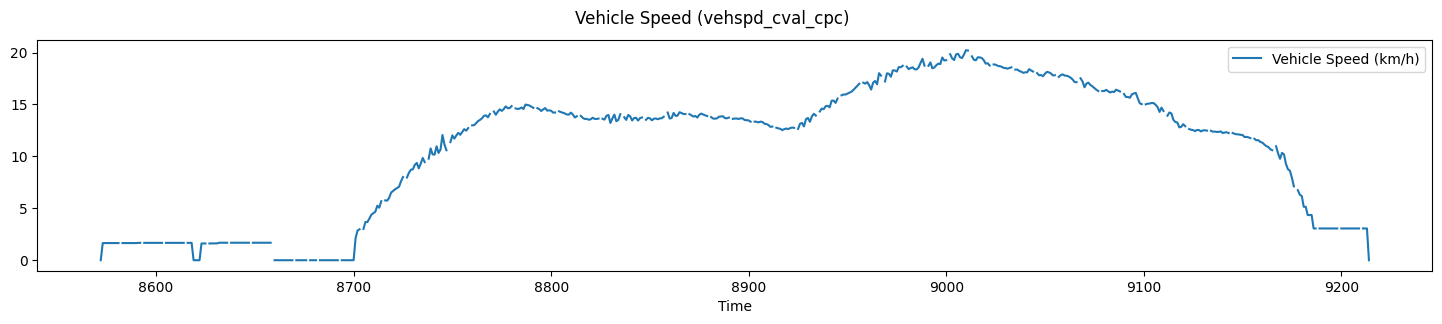

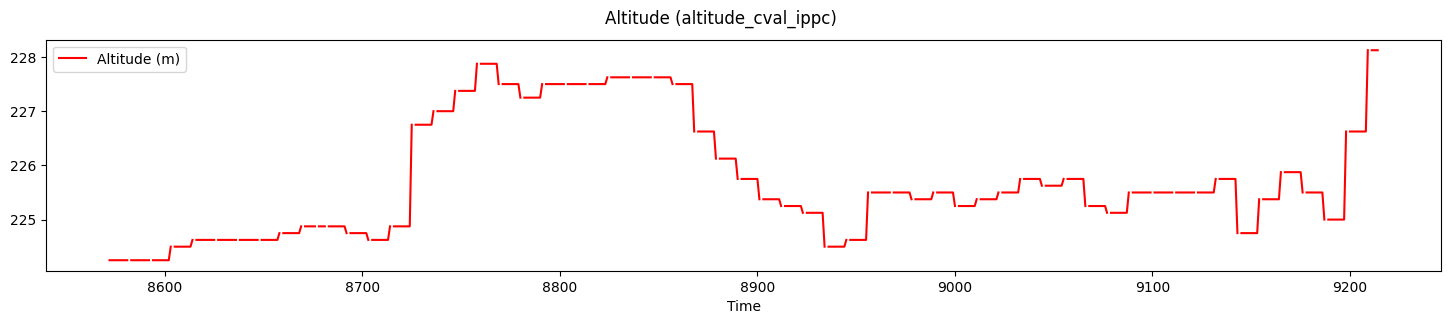

section 1
length: 2238
speed (start, end): (np.float64(0.0), np.float64(2.62109375))


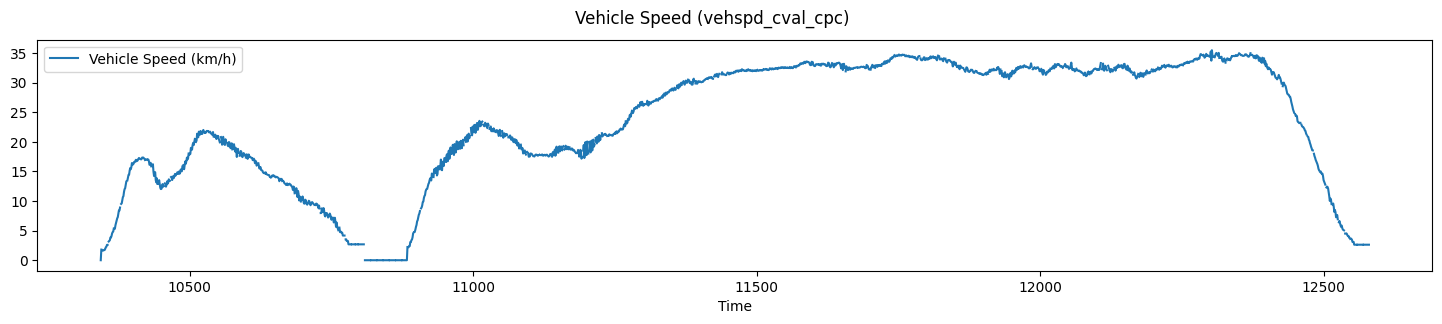

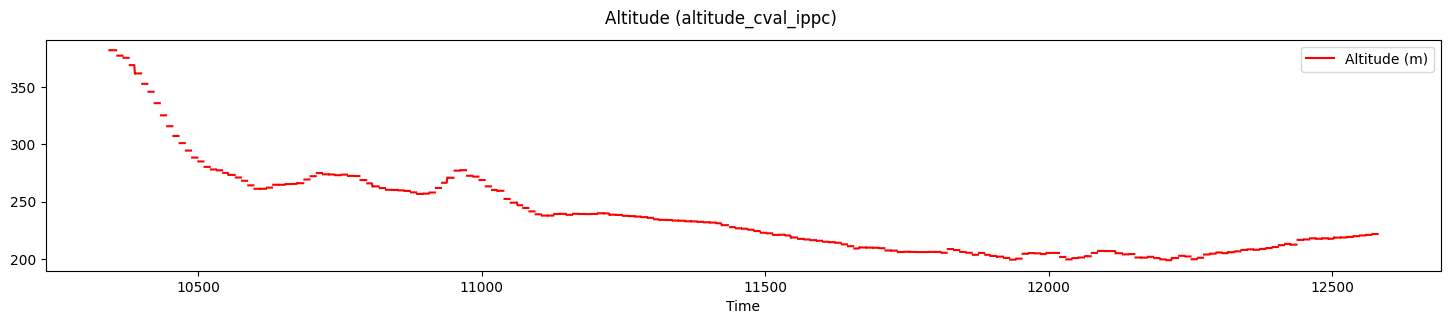

section 2
length: 834
speed (start, end): (np.float64(0.0), np.float64(0.0))


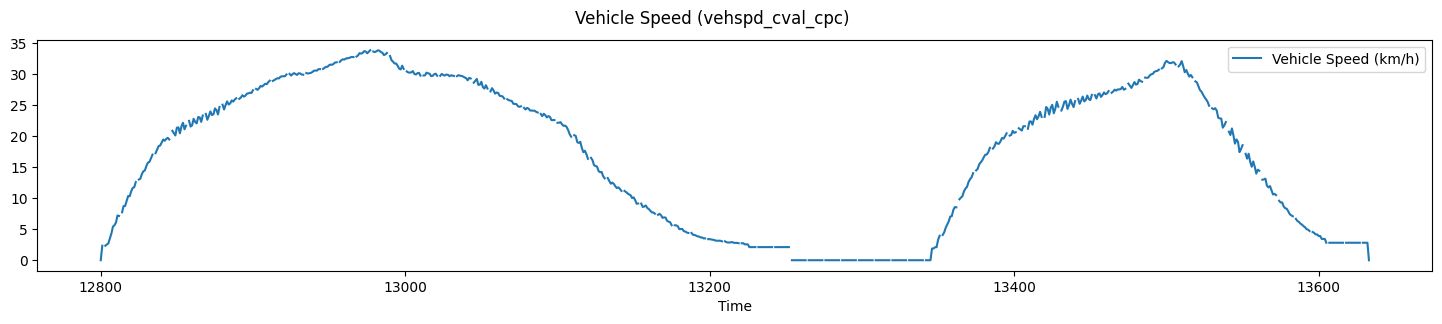

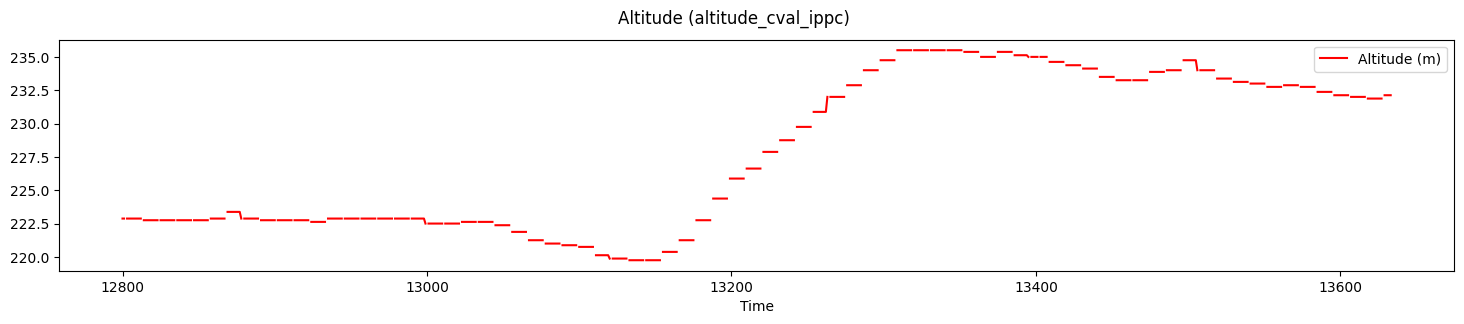

section 3
length: 871
speed (start, end): (np.float64(0.0), np.float64(0.0))


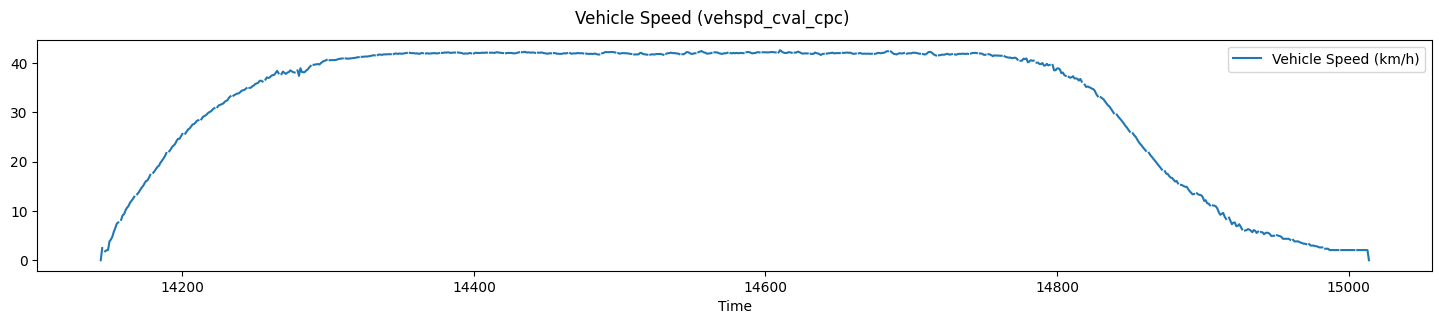

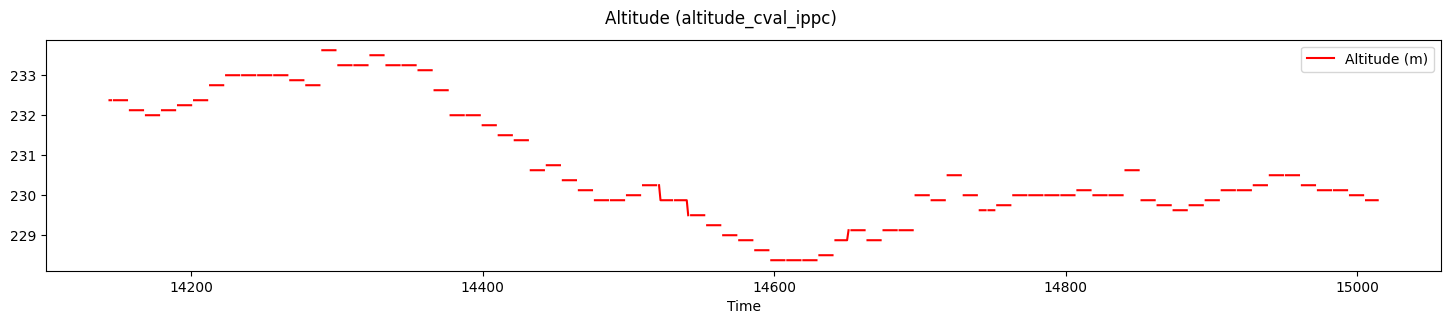

section 4
length: 12851
speed (start, end): (np.float64(0.0), np.float64(0.0))


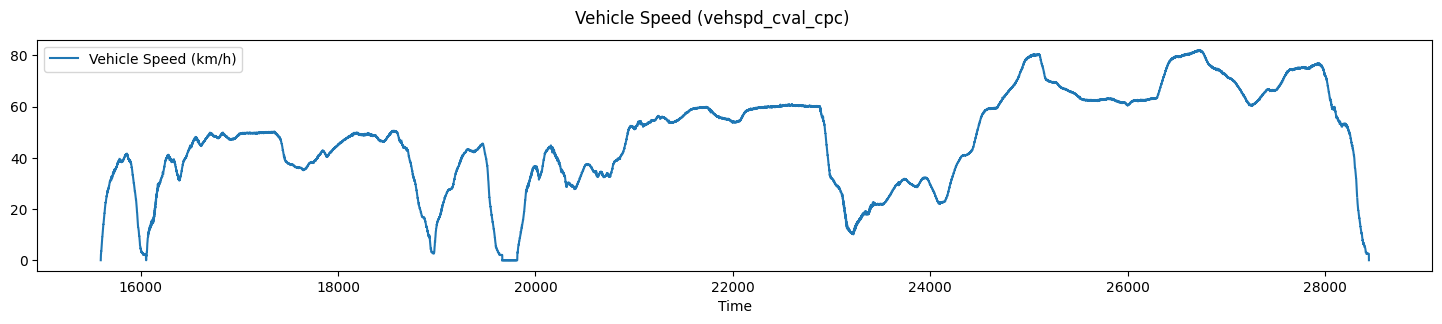

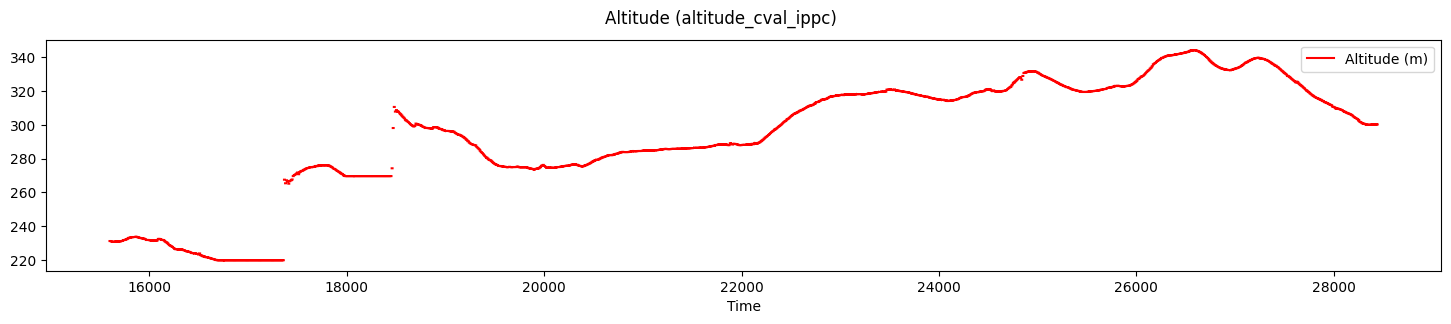

section 5
length: 12827
speed (start, end): (np.float64(0.0), np.float64(0.0))


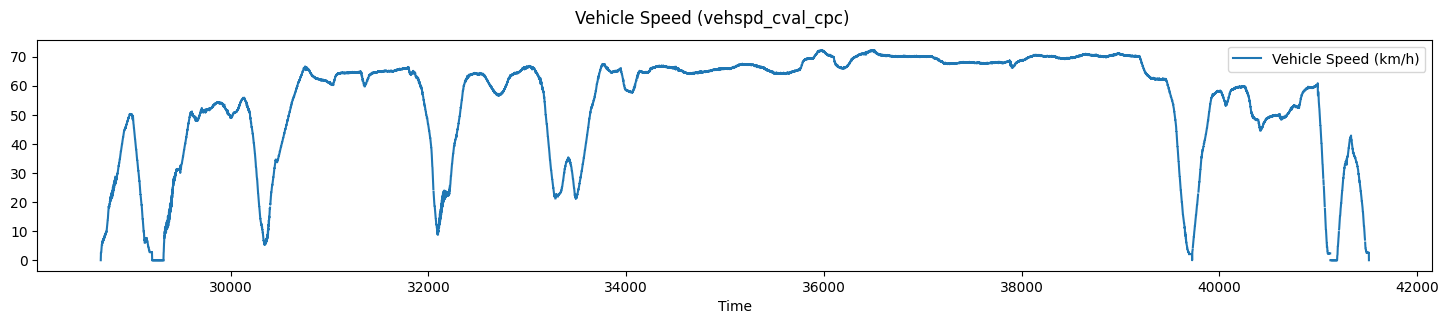

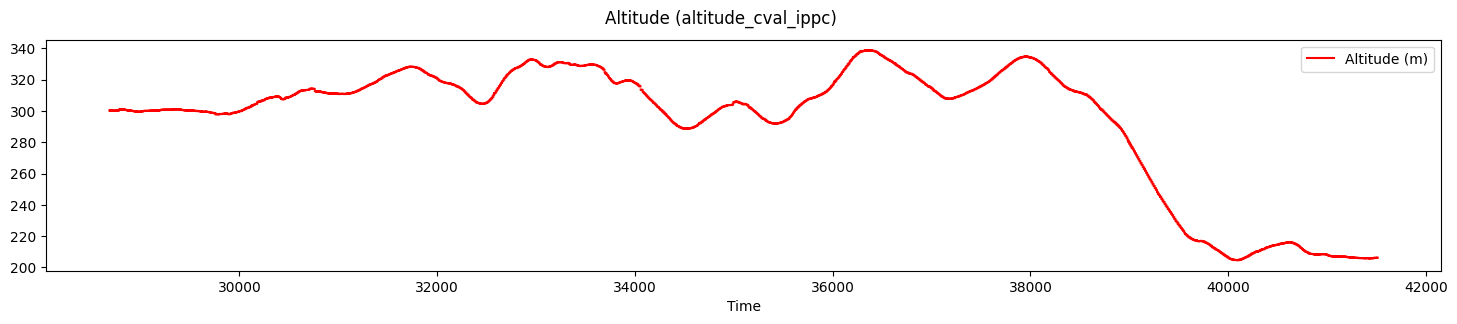

section 6
length: 14012
speed (start, end): (np.float64(0.0), np.float64(0.0))


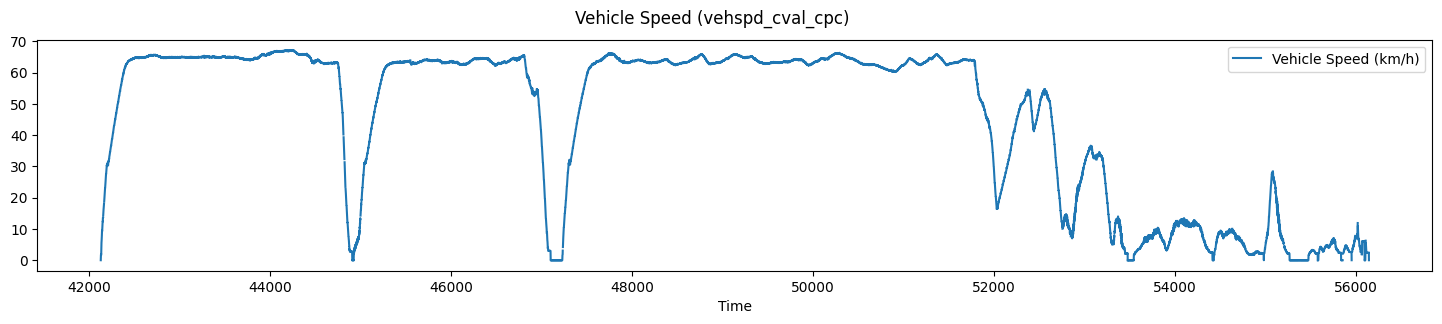

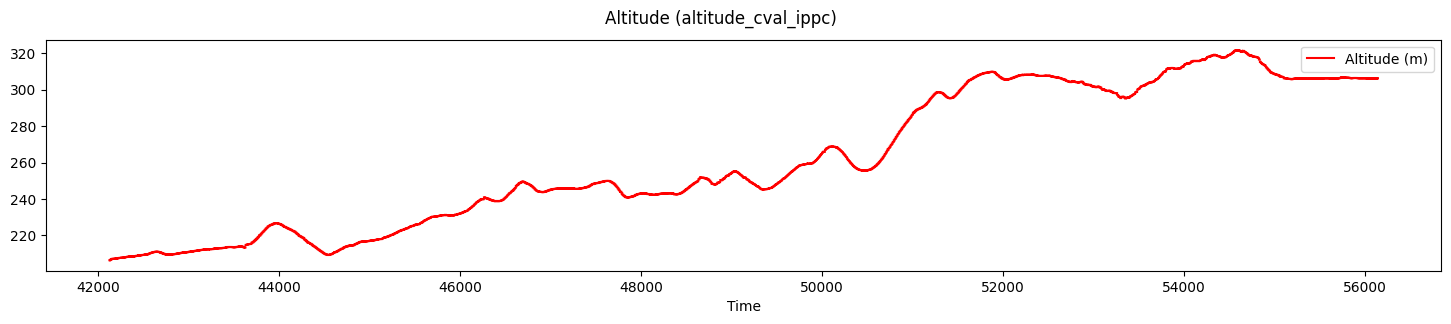

section 7
length: 1177
speed (start, end): (np.float64(1.90625), np.float64(0.0))


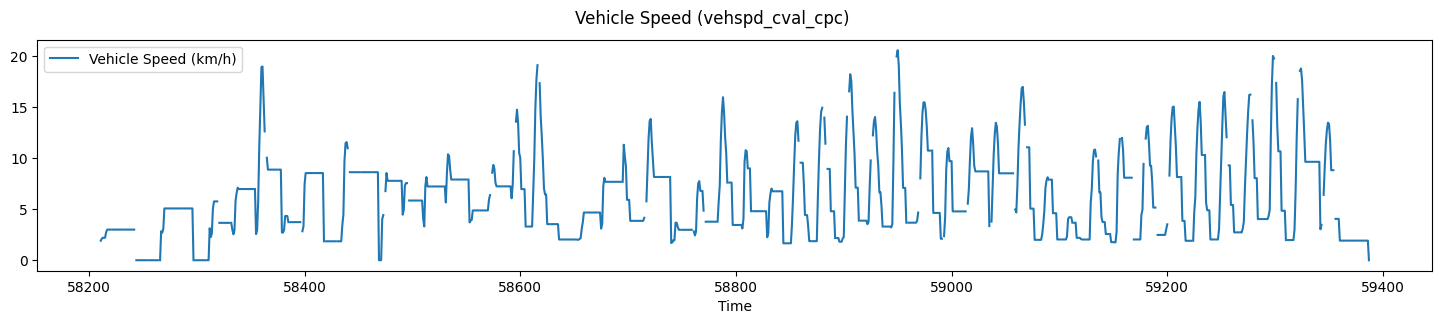

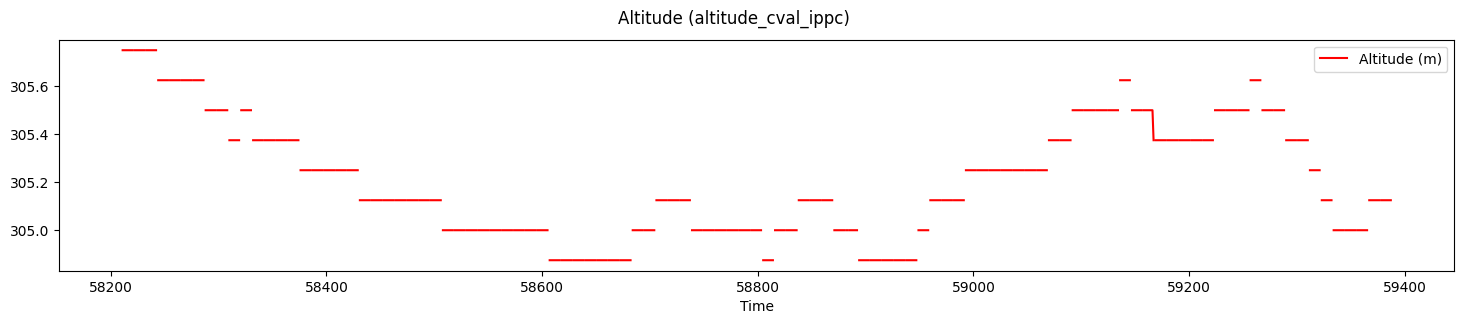

section 8
length: 212
speed (start, end): (np.float64(0.0), np.float64(nan))


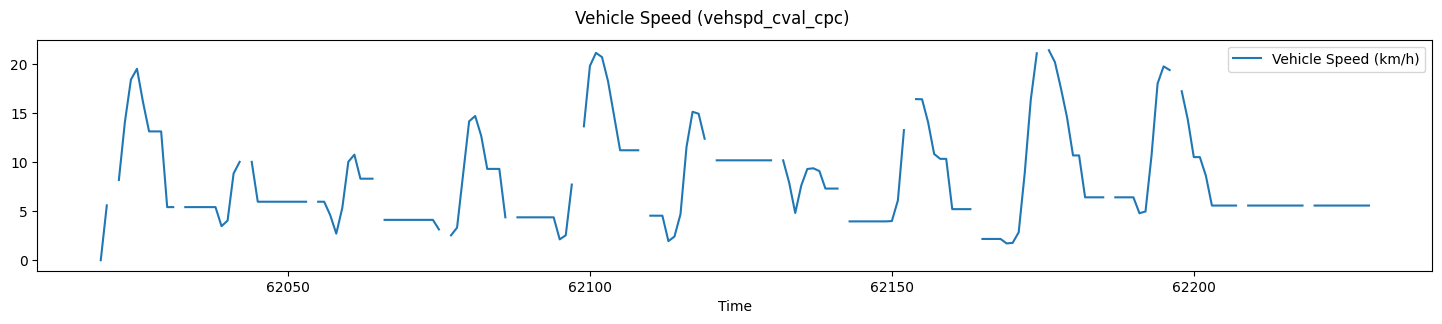

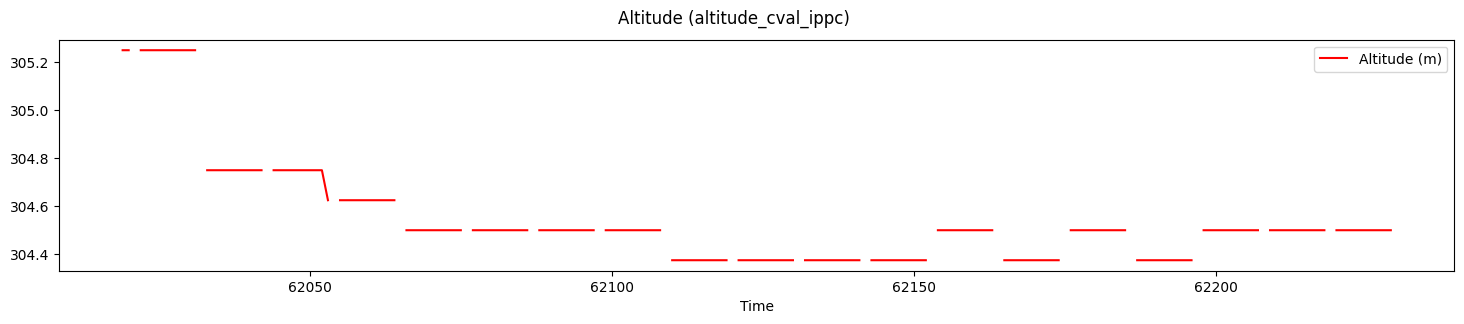

section 9
length: 9882
speed (start, end): (np.float64(0.0), np.float64(0.0))


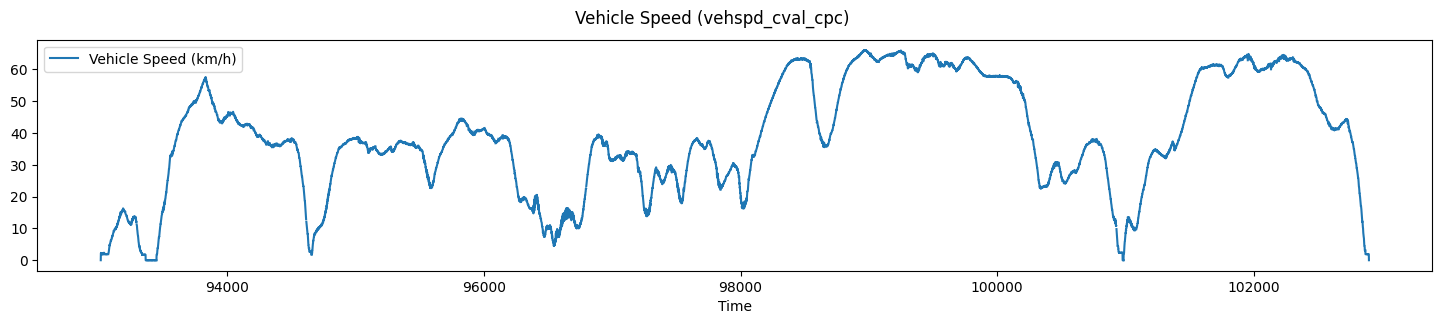

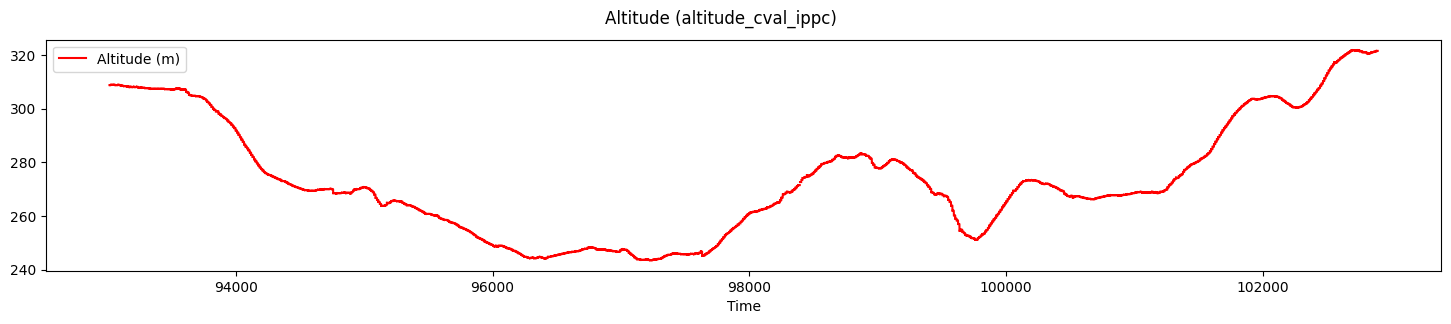

section 10
length: 29936
speed (start, end): (np.float64(0.0), np.float64(0.0))


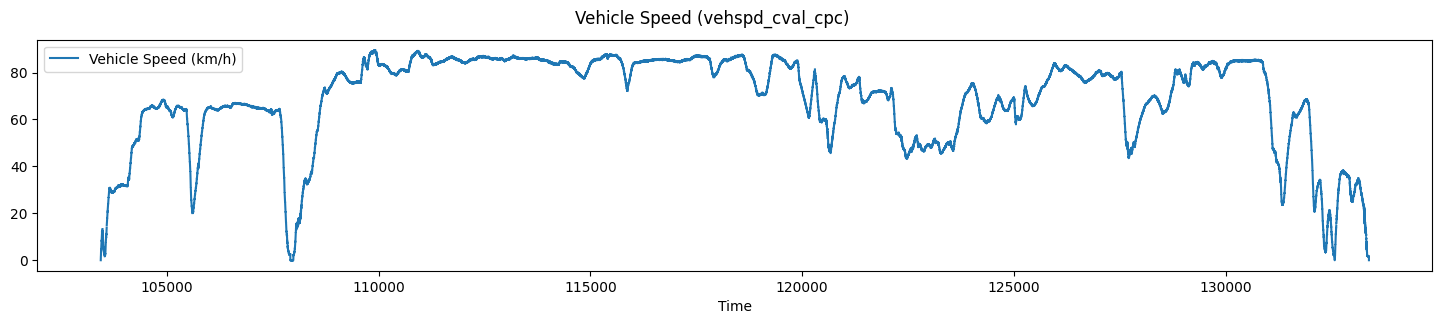

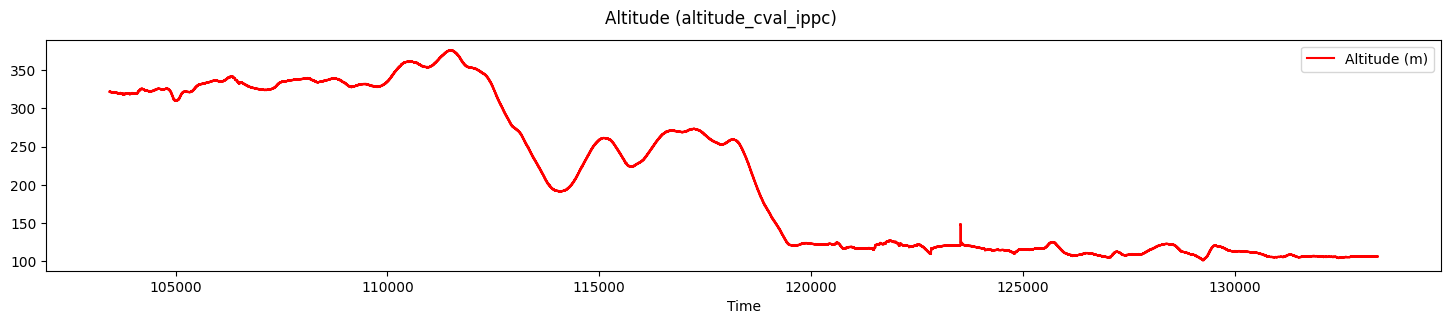

In [27]:
# PLOT EACH SECTION FROM ABOVE IN DETAIL AND SEPERATELY ---------------------------------------------------------------
for n, s in enumerate(sections):
    print(f"section {n}")
    print(f"length: {s.stop - s.start}")
    print(f"speed (start, end): {(v[s].iloc[0], v[s].iloc[-1])}")
    
    v[s].plot(figsize=(18, 3), subplots=True, title='Vehicle Speed (vehspd_cval_cpc)')
    plt.legend(['Vehicle Speed (km/h)']); plt.xlabel('Time'); plt.show()

    alt[s].plot(figsize=(18, 3), subplots=True, color='red', title='Altitude (altitude_cval_ippc)')
    plt.legend(['Altitude (m)']); plt.xlabel('Time'); plt.show()